In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig


## signal generation

In [ ]:
np.random.seed(1024)
x = np.arange(2000).astype(np.float32) / 2000
sa = np.exp(-x) + np.sin(x * 20 * 3.14159) + np.random.randn(2000) / 10 + np.sin(x * 10 * 3.14159) + 0.8*np.sin(x * 15 * 3.14159)
plt.plot(sa)

In [ ]:
sb = np.zeros(2000)
sb[:1990] = sa[10:]
sb[1990:] = np.mean(sa) + np.random.randn(10) / 4
sb += np.random.randn(2000) / 8
plt.plot(sb)

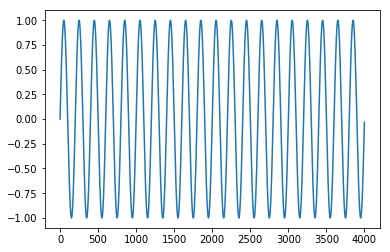

In [2]:
# non-relative
sa = np.arange(4000) / 4000
sb = np.sin(sa * 40 * 3.14159)
plt.plot(sb)

In [ ]:
st = 'signal_a, signal_b\n'
for i, j in zip(sa, sb):
    st += str(i) + ', ' + str(j) + '\n'
with open('non_relative.txt', 'w') as nf:
    nf.write(st)

## data read

In [ ]:
data = pd.read_csv('gauss_noise.txt')
data.head()

In [ ]:
sa = data['CAD'].values
sb = data['BRL'].values

In [ ]:
sa = data['signal_a'].values
sb = data['signal_b'].values

## LoCo

In [15]:
def outMul(vectorA, vectorB):
    return vectorA.reshape(-1, 1).dot(vectorB.reshape(-1, 1).T)
a = np.arange(5)
b = np.array([4, 3, 2, 5 ,1])
outMul(a, b)

array([[ 0,  0,  0,  0,  0],
       [ 4,  3,  2,  5,  1],
       [ 8,  6,  4, 10,  2],
       [12,  9,  6, 15,  3],
       [16, 12,  8, 20,  4]])

In [23]:
k = 1
w = 10
m = 10
beta = 0.6

In [24]:
outMat_a = []
outMat_b = []
for i in range(len(sa) - w):
    outMat_a.append(outMul(sa[i:i+w], sa[i:i+w]))
    outMat_b.append(outMul(sb[i:i+w], sb[i:i+w]))
len(outMat_a)

3990

In [25]:
slideMat_a = [sum(outMat_a[:m])]
for i in range(m+1, len(outMat_a)):
    slideMat_a.append(slideMat_a[-1] - outMat_a[i-m-1] + outMat_a[i])

In [26]:
slideMat_b = [sum(outMat_b[:m])]
for i in range(m+1, len(outMat_b)):
    slideMat_b.append(slideMat_b[-1] - outMat_b[i-m-1] + outMat_b[i])

In [27]:
expMat_a = [outMat_a[0]]
expMat_b = [outMat_b[0]]
for i in range(1, len(outMat_a)):
    scale = (1 - beta) / (1 - beta ** (1+i))
    expMat_a.append((beta * expMat_a[-1] + outMat_a[i]) * scale)
    
    expMat_b.append((beta * expMat_b[-1] + outMat_b[i]) * scale)

In [28]:
def loco(ux, uy, wa, wb):
    first = np.linalg.norm(ux.dot(wb.reshape(-1, 1)))
    second = np.linalg.norm(uy.dot(wa.reshape(-1, 1)))
    return 0.5 * (first + second)

score = []
for ma, mb in zip(expMat_a, expMat_b):
    _, va = eig(ma)
    _, vb = eig(mb)
    ux = va[:, :k].T
    uy = vb[:, :k].T
    
    score.append(loco(ux, uy, va[:, 0], vb[:, 0]))

In [29]:
%matplotlib qt
#score[0] = 1.0
fig, axes = plt.subplots(2, 1)
axes[0].plot(range(len(sa)), sa, range(len(sb)), sb)
axes[1].plot(score)

In [14]:
mat = outMat_a[0]
u, v, _ = np.linalg.svd(mat)
u.shape

(10, 10)

In [ ]:
eig(np.arange(4).reshape(2, 2))

In [ ]:
0.96277**2 + 0.2703**2